In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import src.utilerias.reader as rd
import src.utilerias.utilerias as utls

# Llamamos a la función antes de ejecutar el script
logs_dir = 'logs/NARNN/estandar'
logs_dir_auto_pred = 'logs/NARNN/auto_predictiva'
utls.eliminar_archivos_registro(logs_dir)
utls.eliminar_archivos_registro(logs_dir_auto_pred)

In [2]:
# DATOS = 'cierre.csv'#Grupo Financiero Inbursa
# DATOS = 'Datos históricos COMI 03012016_27122020.csv' #Datos originales
DATOS = 'datos/Datos históricos COMI 3ene16-31dic2020 semanal.csv' #Datos semanales
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020.csv' #Datos semanales de prueba
# DATOS = 'Datos históricos COMI3ene2016_27dic2020_diario.csv' #Datos originales diarios de prueba
# DATOS = 'Datos históricos COMI_prueba 30jun19-31dic2020_DIARIO.csv' #Datos diarios de prueba

cierre = rd.leer_archivo(DATOS).astype(float)

In [3]:
#Se crean los conjuntos de entradas y salidas para la red, que funcionaran para predecir y comparar con las salidas esperadas a la hora de realizar el entrenamiento
time_steps = 8 # la cantidad de semanas anteriores a partir de las cuales se va a predecir la novena semana

#Obtenemos el conjunto de entrenamiento
c_entrenamiento = np.array(cierre[:int(len(cierre) * 0.7)])

precios_reales = cierre[int(len(cierre) * 0.7):] #verdaderos valores del conjunto de prueba

#Se concatenan los ultimo 8 elementos del conjunto de entrenamiento para predecir el primero del conjunto de prueba
# ahora cada uno de los arreglos dentro de components_p y components_p_n tiene forma (84,)
c_prueba = cierre[len(cierre) - len(precios_reales) - time_steps:]

#Se normalizan cada uno de los elementos de los vectores contenidos en las descomposicion de la serie de tiempo original
c_entrenamiento_n = utls.normalizar(c_entrenamiento) # componentes de entrenamiento normalizados
c_prueba_n = utls.normalizar(c_prueba) # componentes de prueba normalizados len 78

In [4]:
from src.modelos.auto_regresivo.NARNN.NARNN import NARNN
from src.modelos.auto_regresivo.entrenamientos.entrenamiento import Entrenamiento as entr

red = NARNN(input_dim=8, hidden_dim=0, num_layers= 0, output_dim=1, nombre="NARNN")
#red.load_state_dict(torch.load('redes/NARNN/estandar/red.pth'))
#red.eval()

entrenamiento_8_1 = [[]]
prueba_8_1 = [[]]

# A cada uno de los conjuntos de entrenamiento se les da una forma de entrada en especifico,
# que es un arreglo de 8 y uno de un solo elemento para representar la salida

entrenamiento_8_1[0] = utls.corrimiento_t_1(c_entrenamiento_n,9) # list(tensor[()]*) una lista de 174 tensores con 9 elementos cada uno
prueba_8_1[0] = utls.corrimiento_t_1(c_prueba_n,9) # list(tensor[()]*) una lista de 78 tensores con 9 elementos cada uno

# Se realiza el entrenamiento de cada una de las redes y se guarda el modelo ya entrenado

entr_red = entr(red,0,writer_dir=logs_dir)
entr_red.entrena_lm(entrenamiento_8_1[0],epocas=5,lr=0.01,λ=0.1,e_predictivo=False)
torch.save(red.state_dict(), 'redes/NARNN/red_NARNN.pth') #Salvamos el estado actual del modelo


---INICIO DE ENTRENAMIENTO: entrena_LM---
---Inicio de epoca: 0--
-----> Predicción pre entreno: tensor([-0.1284], grad_fn=<ViewBackward0>) 
>>Paso...<<
>>Fin de paso<<
>>Se calcula perdida despues del paso...
entrada: tensor([0.1201, 0.0198, 0.0000, 0.0186, 0.0566, 0.0260, 0.0345, 0.0422])
----->Salida de la red: tensor([-0.1268], grad_fn=<ViewBackward0>)
----->Salida esperada: tensor([0.0461])
Lambda: 0.05
lr: 0.01, batch: 1
-----> Predicción pre entreno: tensor([-0.1274], grad_fn=<ViewBackward0>) 
>>Paso...<<
>>Fin de paso<<
>>Se calcula perdida despues del paso...
entrada: tensor([0.0198, 0.0000, 0.0186, 0.0566, 0.0260, 0.0345, 0.0422, 0.0461])
----->Salida de la red: tensor([-0.1252], grad_fn=<ViewBackward0>)
----->Salida esperada: tensor([0.1042])
Lambda: 0.05
lr: 0.01, batch: 2
-----> Predicción pre entreno: tensor([-0.1244], grad_fn=<ViewBackward0>) 
>>Paso...<<
>>Fin de paso<<
>>Se calcula perdida despues del paso...
entrada: tensor([0.0000, 0.0186, 0.0566, 0.0260, 0.0345, 0.0

# Predicción del conjunto de prueba

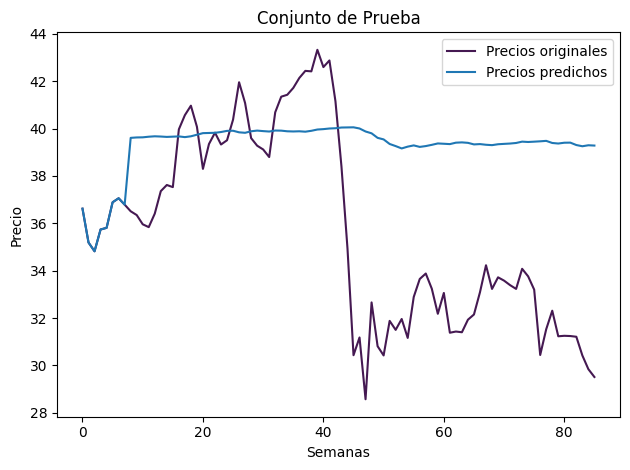

Perdida: 29.140090174497164


In [19]:
#Se grafica el conjunto de entrenamiento
criterion = nn.MSELoss()

prediccion = utls.genera_prediccion_1(prueba_8_1[0],red,8)
precios_predichos = utls.desnormalizar(prediccion,np.max(c_prueba),np.min(c_prueba)).detach().numpy()
plt.plot(c_prueba, color = '#451952', label = 'Precios originales') 
plt.plot(precios_predichos, label = 'Precios predichos')
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Perdida: {float(criterion(torch.tensor(precios_predichos), torch.tensor(c_prueba)))}")

# Evaluación de desempeño

In [20]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(c_prueba,precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(c_prueba,precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(c_prueba,precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                          RMSE    MAPE       DS
Precicción de c_prueba  5.3982  13.111  46.5116


# Generamos el entrenamiento predictivo

In [11]:
# Definimos el número de epocas
EPOCAS = 10

In [12]:
model_path = f'redes/NARNN/auto_predictiva/red_NARNN.pth'
red.load_state_dict(torch.load(model_path))
red.eval()

entr = entr(red,0, logs_dir_auto_pred)
entr_red.entrena_lm(entrenamiento_8_1[0],EPOCAS,lr=0.5,λ=0.1,batch_size=8,decay_factor=5,e_predictivo=True)
# torch.save(networks[0].state_dict(), 'redes/DWT_NARNN/red_A5_pred') #Salvamos el estado actual del modelo

# red.save_weights(f'redes/LSTM/auto_predictiva/LSTM.h5')

Ejemplar x: [[0.12010849]
 [0.01975978]
 [0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]] | y: 0.04610616040294452 | Predicción actual: [[0.24802819]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.037179067730903625, batch 1, lote_designado 1
lr: 1e-05, batch: 1
>Fin lote<
Ejemplar x: [[0.01975978]
 [0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]
 [0.24802819]] | y: 0.10422316931421921 | Predicción actual: [[0.23225437]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.01266101561486721, batch 2, lote_designado 1
lr: 1e-05, batch: 2
>Fin lote<
Ejemplar x: [[0.        ]
 [0.01859744]
 [0.05656722]
 [0.02595893]
 [0.03448276]
 [0.04223169]
 [0.24802819]
 [0.23225437]] | y: 0.15420379697791559 | Predicción actual: [[0.23611084]]
Lr que voy a aplicar en el lote es 9.999999747378752e-06
loss en el callback: 0.00687388563528657, batch 3, lote_designado 1
lr: 

[0.12389325726463696,
 0.12413302685184611,
 0.12323438427770847,
 0.12623179922523325,
 0.12604638479775437,
 0.12475872666667186,
 0.12484375408626758,
 0.125682004703958,
 0.1263528139438373,
 0.12674657241689505,
 0.12589410494411785,
 0.12449866194134936,
 0.12634070525681043,
 0.1279924332076849,
 0.12829748170562602,
 0.12755625731091752,
 0.1315207039619848,
 0.13312295156628293,
 0.12882559586411227,
 0.12777923010741646,
 0.1315239279458558,
 0.12938529643134744,
 0.13048129882696166,
 0.13084827611584668,
 0.1362778290391154,
 0.12916345450028976,
 0.1306183549338757,
 0.13243951262175052,
 0.13117282358844592,
 0.13346561270078733]

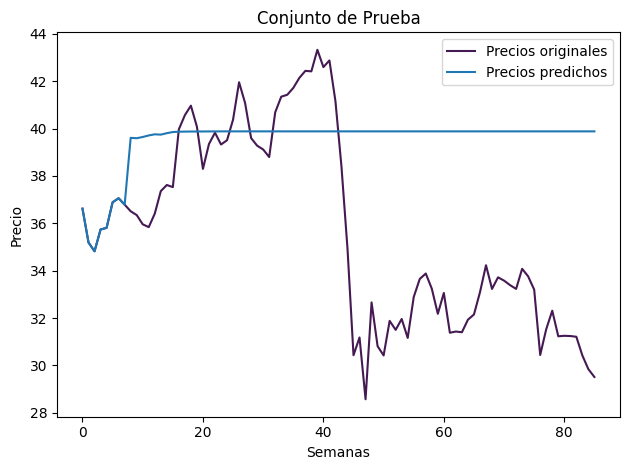

Perdida: 32.46885432713034


In [21]:
# Predice el conjunto de entrenamiento usando la prediccion predictiva a partir de los primeros (usando los datos que predice)
prediccion_ap = utls.genera_prediccion_predictiva(prueba_8_1[0][0][:8],8,len(prueba_8_1[0]),red)
red_ap_precios_predichos = utls.desnormalizar(prediccion_ap,np.max(c_prueba),np.min(c_prueba)).detach().numpy()

plt.plot(c_prueba, color = '#451952', label = 'Precios originales')
plt.plot(red_ap_precios_predichos, label = 'Precios predichos')#label=f"Datos de Analisis: {DATOS}",
plt.title('Conjunto de Prueba')
plt.xlabel('Semanas')
plt.ylabel('Precio')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Perdida: {float(criterion(torch.tensor(red_ap_precios_predichos), torch.tensor(c_prueba)))}")


In [22]:
import pandas as pd
r_c_prueba_txt = 'Precicción de c_prueba'
# Supongamos que tenemos una lista de errores de predicción para cada red neuronal
rmse = {
    r_c_prueba_txt: utls.rmse(c_prueba,red_ap_precios_predichos)
}
mape = {
    r_c_prueba_txt: utls.mape(c_prueba,red_ap_precios_predichos)
}
ds = {
    r_c_prueba_txt: utls.directional_symmetry(c_prueba,red_ap_precios_predichos)
}

# Creamos un DataFrame de Pandas a partir del diccionario de errores
df_errores = pd.DataFrame({
    'RMSE': pd.Series(rmse),
    'MAPE': pd.Series(mape),
    'DS': pd.Series(ds)
})

# Mostramos el DataFrame con los errores
print(df_errores) 

                          RMSE     MAPE       DS
Precicción de c_prueba  5.6981  13.8056  83.7209
